# Eiffel Tower vs Wat Arun (Temple of Dawn) 


Eiffel Tower is a famous landmark in Paria, France. Wat Arun or the Temple of Dawn is a famous landmark along the Chaopraya River in Bangkok, Thailand. They has similar structure, but very different architecture. This project is trying to classify pictures of these two places with convolution neural network. 

Images are obtain by google images of the two places.There are about 600 pictures, which are randomly splitted into train (70%), test(20%) and valid (10%) folders. I  implement the procedure I learned from fast.ai. 

In [1]:
#setup the notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline

#import libs 

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#Setup PATH

PATH = "../../../data/EiffelWat/"

In [3]:
torch.cuda.is_available()
torch.backends.cudnn.enabled

True

In [4]:
#explore directories
!ls {PATH}

os.listdir(f'{PATH}valid')

models	test  test2  tmp  train  valid


['EiffelT', 'WatArun']

## First look at Wat Arun

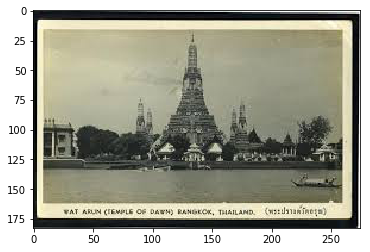

In [5]:
files=os.listdir(f'{PATH}valid/WatArun')
len(files)

img=plt.imread(f'{PATH}valid/WatArun/{files[0]}')
plt.imshow(img)

##Picture of Eiffel Tower

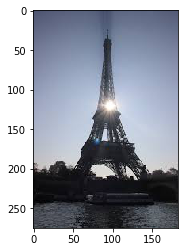

In [6]:
files=os.listdir(f'{PATH}valid/EiffelT')
len(files)

img=plt.imread(f'{PATH}valid/EiffelT/{files[5]}')
plt.imshow(img)

Look at distribution of pixel width and height in the training set.

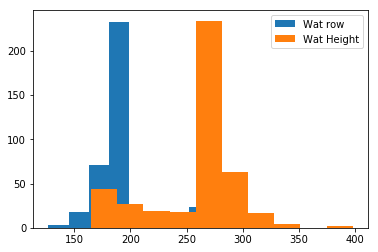

In [7]:
wat_row = []
wat_col = []

wat_trn=os.listdir(f'{PATH}train/WatArun')

for file in wat_trn:
    wat_row.append(plt.imread(f'{PATH}train/WatArun/{file}').shape[0])
    wat_col.append(plt.imread(f'{PATH}train/WatArun/{file}').shape[1])

plt.hist(wat_row)
plt.hist(wat_col)
plt.legend(['Wat row','Wat Height'])

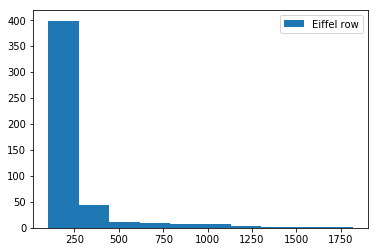

In [8]:
eiffel_row = []
eiffel_col = []

eiffel_trn=os.listdir(f'{PATH}train/EiffelT')

for file in eiffel_trn:
    eiffel_row.append(plt.imread(f'{PATH}train/EiffelT/{file}').shape[0])
    eiffel_col.append(plt.imread(f'{PATH}train/EiffelT/{file}').shape[1])

eiffel_row = [row for row in eiffel_row if row <2000]  
eiffel_col = [col for col in eiffel_col if col <2000]  
plt.hist(eiffel_row)
plt.legend(['Eiffel row'])

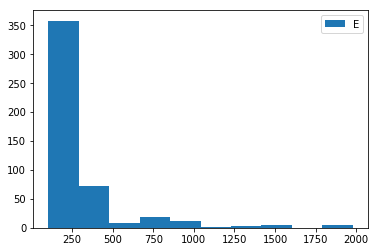

In [9]:
plt.hist(eiffel_col)
plt.legend('Eiffel Height')

Most of Eiffel Tower images are square, while Wat Arun images are rectangular. People really like to take a wide-angle picture of Wat Arun. 

## First model (a quick start)

I used pre-trained model from ImageNet. In this first attempt, I use **restnet34** model. 

In [10]:
#setup model and image size
arch=resnet34
sz=250 #size that image will be resized to.
bs=20
data = ImageClassifierData.from_paths(PATH,bs=bs, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 5)

epoch      trn_loss   val_loss   accuracy                 
    0      0.319732   0.114959   0.965517  
    1      0.222554   0.111267   0.952586                 
    2      0.186666   0.140314   0.943966                 
    3      0.155441   0.140026   0.961207                 
    4      0.120668   0.156886   0.956897                 



[array([0.15689]), 0.956896541447475]

 I played around with the batch size (bs) and sz. The former because I don't have a large set of images and the later because a lot of Wat Arun images are not square. Then obtain 98% accuracy, after the 4th epoch. Let's explore the results. Pick random images from the validation set to see what is most confident and lease confident classifications.


In [11]:
data.classes

['EiffelT', 'WatArun']

Eiffel is labeled 0 and Wat Arun is labeled 1. 

In [12]:
#look at prediction from validation set. 
#Its dimension is equal to the files in the validation set.
log_preds=learn.predict()
#preds is 0 if Eiffel and 1 if Wat Arun
preds=np.argmax(log_preds,axis=1)
probs=np.exp(log_preds[:,1]) #probability of Wat Arun

In [13]:
#data.val_y label the validation set
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

Correctly classified


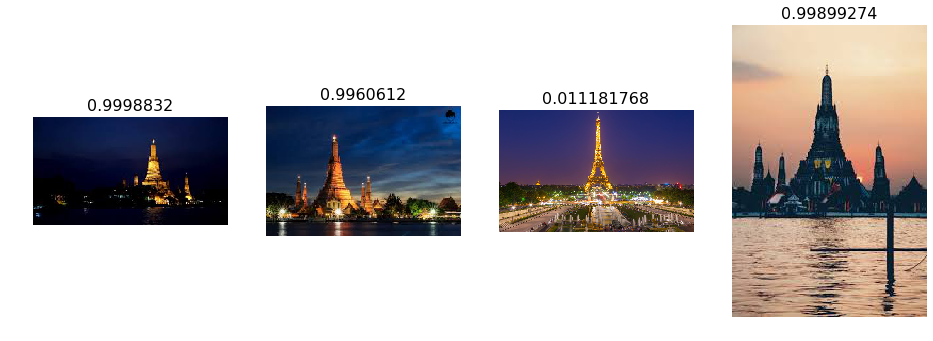

In [14]:
# correctly classified images
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


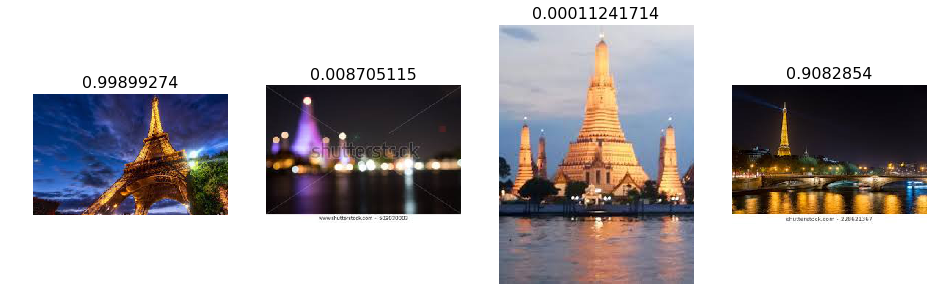

In [15]:
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [16]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most incorrect Eiffel


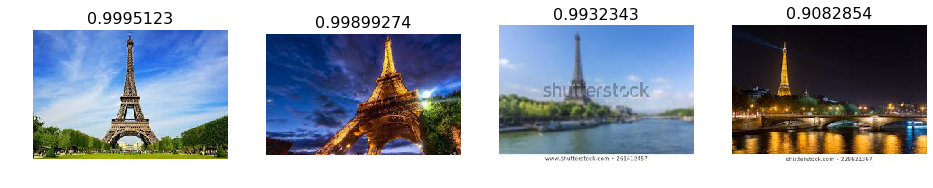

In [17]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect Eiffel")

Most incorrect Wat Arun


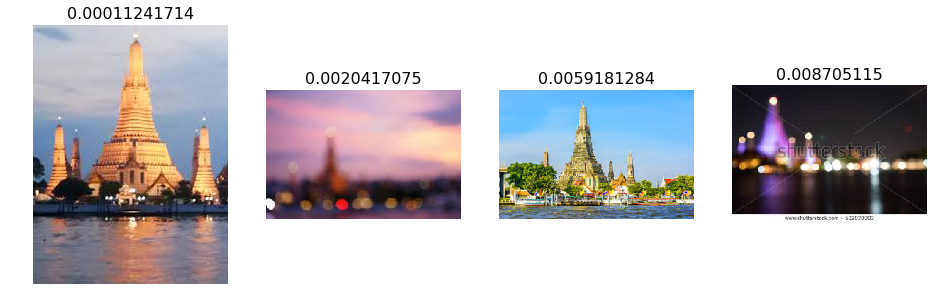

In [18]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect Wat Arun")

## Optimizing the model: data augmentation 

There are two ways to improve the model.
    1. Choosing a learning rate
    2. Data augmentation
    
Data augmentation randomly change the images by: flipping, zooming, rotation, stretching, changing lighting parameters, and padding. I use fastai library to play with augmentation: adding rotation, change lighting, and add padding into the training sets. 


In [19]:
# transformation 
tranformations = [RandomRotate(5),RandomLighting(0.2, 0.2,tfm_y=TfmType.NO),AddPadding(pad=30, mode=cv2.BORDER_REPLICATE)]
tfms = tfms_from_model(resnet34, sz, aug_tfms=tranformations,max_zoom=1.1)

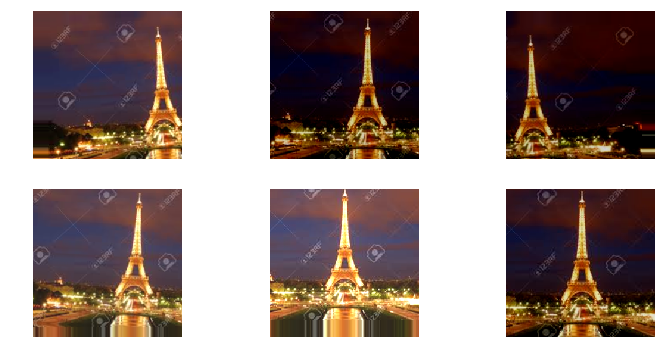

In [20]:
# explore image augmentation
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]
ims = np.stack([get_augs() for i in range(6)])
plots(ims, rows=2)

In [21]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.02,5)

epoch      trn_loss   val_loss   accuracy                 
    0      0.354734   0.099913   0.969828  
    1      0.208265   0.090511   0.961207               
    2      0.164947   0.085184   0.965517                 
    3      0.155893   0.097613   0.965517                 
    4      0.138346   0.087675   0.969828                 



[array([0.08767]), 0.969827584151564]

In [22]:
#saving the result 
learn.save('250_all')
learn.load('250_all')

## Analyzing results

### Confusion Matrix

In [23]:
# user test time augmentation to find the accuracy

log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

0.9698275862068966

In [24]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[124   3]
 [  4 101]]


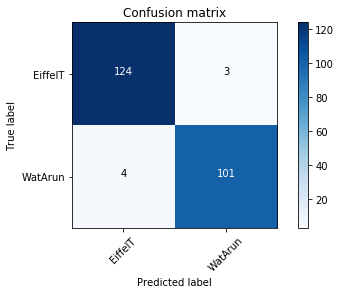

In [25]:
plot_confusion_matrix(cm, data.classes)

# Summary

In this document, I use a CNN and pre-train resnet34 model to diccern image of Eiffel Tower and Wat Arun. I got about 96% accuracy. Using a fast.ai, augmentation library slightly improve the accuracy, while using differential learning rate does not help. The next step is trying another models, playing with augmentation, adding more training sets. 